<a href="https://colab.research.google.com/github/Samarth-991/Intel-Dataset-Classification/blob/main/Latency_comparision_image_classification_TFlite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intel Image Classifiaction Dataset 
This is image data of Natural Scenes around the world.

In [ ]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d puneet6060/intel-image-classification
# ! unzip /content/intel-image-classification.zip
# ! rm -rf /content/intel-image-classification.zip
# ! rm -rf logs

In [2]:
import numpy as np
import csv
import pandas as pd
import time
import cv2
import os
import glob
import random
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from  tensorflow.keras.preprocessing import image
import gc 
print(tf.__version__)
print(cv2.__version__)
rand = np.random.seed(46)

train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred/seg_pred'

2.4.1
4.1.2


In [3]:
train_imgs = glob.glob(train_path+'/*/*.jpg')
print("Total number of training images :",len(train_imgs))

test_imgs = glob.glob(test_path+'/*/*.jpg')
print("Total number of training images :",len(test_imgs))

pred_imgs = glob.glob(pred_path+'/*.jpg')
print("Total number of training images :",len(pred_imgs))

Total number of training images : 14034
Total number of training images : 3000
Total number of training images : 7301


In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
EPOCHS = 10
INIT_LR = 1e-3

CLASS_NAMES = np.array([item for item in os.listdir(train_path)])
print (CLASS_NAMES)

['forest' 'sea' 'mountain' 'glacier' 'buildings' 'street']


In [5]:
for label in CLASS_NAMES:
  print("Train images for {} is {}".format(label,len(os.listdir(os.path.join(train_path,label)))))
print('\n')
for label in CLASS_NAMES:
  print("Test images for {} is {}".format(label,len(os.listdir(os.path.join(test_path,label)))))

Train images for forest is 2271
Train images for sea is 2274
Train images for mountain is 2512
Train images for glacier is 2404
Train images for buildings is 2191
Train images for street is 2382


Test images for forest is 474
Test images for sea is 510
Test images for mountain is 525
Test images for glacier is 553
Test images for buildings is 437
Test images for street is 501


In [6]:
def generate_imgdataframe(data,save_as='train.csv'):
    labels = []
    filenames = []
    image_shape = []
    for imgfile in data:
        filename = os.path.basename(imgfile)
        label = os.path.basename(os.path.split(imgfile)[0])
        img = plt.imread(imgfile)
        
        image_shape.append(img.shape)
        labels.append(label)
        filenames.append(filename)
    df = pd.DataFrame({'filename':filenames,'Class':labels,'shape':image_shape})
    df.to_csv(save_as)
    return df

In [7]:
plt.figure(figsize=(5,5))
if not os.path.isfile('/content/train.csv'):
    train_data = generate_imgdataframe(train_imgs,'train.csv')
train_data = pd.read_csv('/content/train.csv')
train_data.head()

,Unnamed: 0,filename,Class,shape
0,0,10786.jpg,forest,"(150, 150, 3)"
1,1,10513.jpg,forest,"(150, 150, 3)"
2,2,6661.jpg,forest,"(150, 150, 3)"
3,3,18485.jpg,forest,"(150, 150, 3)"
4,4,4983.jpg,forest,"(150, 150, 3)"


<Figure size 360x360 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


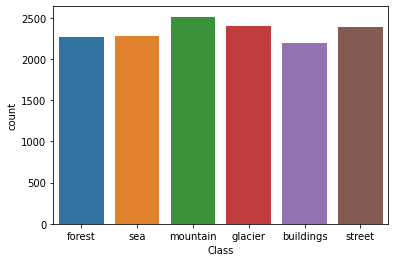

In [8]:
sns.countplot(train_data['Class'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


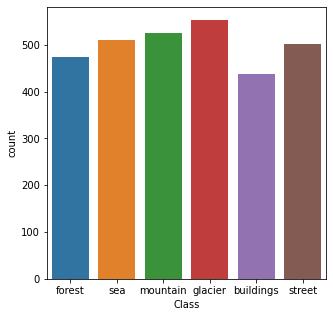

In [9]:
plt.figure(figsize=(5,5))
if not os.path.isfile('/content/test.csv'):
    test_data = generate_imgdataframe(test_imgs,'test.csv')
test_data = pd.read_csv('/content/test.csv')
sns.countplot(test_data['Class'])

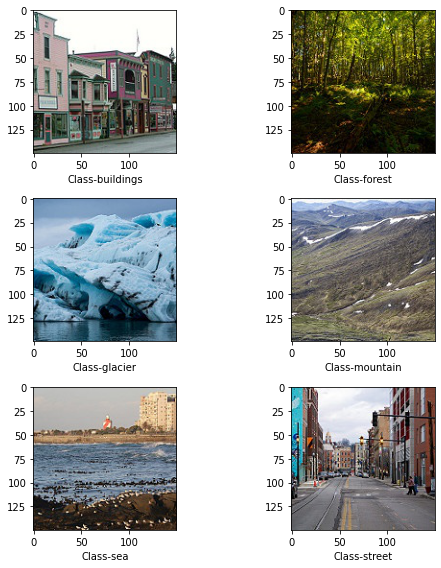

In [10]:
df = train_data.groupby(['Class'])['filename']
imgs_perId = []
for id , name in df:
    img_path = os.path.join(str(id),name[random.choice(name.index)])
    imgs_perId.append(img_path)

# Display Multiple images in a matix 
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 3

for i in range(1, columns*rows +1):
    img = plt.imread(os.path.join(train_path,imgs_perId[i-1]))
    fig.add_subplot(rows, columns, i,xlabel="Class-"+imgs_perId[i-1].split('/')[0])
    plt.imshow(img)
fig.tight_layout()

In [11]:
# This is one of the ways to create training data batch and label batch 
image_generator = image.ImageDataGenerator(rescale=1./255,
                                rotation_range=2,
                                zoom_range=[2,5],
                                brightness_range=[2,5],
                                #width_shift_range=0.2,
                                #height_shift_range=0.2,
                                horizontal_flip=False,
                                )

train_data_gen = image_generator.flow_from_directory(directory=str(train_path),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical',
                                                target_size=(160,160),
                                                classes = list(CLASS_NAMES)
                                                )

validation_generator = image_generator.flow_from_directory(test_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(160,160),
                                                    classes = list(CLASS_NAMES)
                                                    )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2,InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [13]:
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [14]:
# Define Hyperparameters 
opt = Adam(lr=0.01)

# Define Check point 
checkpoint_path = "InceptionV3_training/cp.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,
                            monitor='val_loss', 
                            verbose=1,
                            save_best_only=True)
callbacks_list = [cp_callback,tensorboard_callback]

In [15]:
def define_model(n_layers=150,BASE_MODEL='ResNet50V2'):
    if BASE_MODEL =='ResNet50V2':
        # Pre-trained model with MobileNetV2
        base_model = ResNet50V2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=False
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.2)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    
    if BASE_MODEL =='InceptionV3':
        base_model = InceptionV3(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=False
        
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.5)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    return model

# define Model 
intel_model= define_model(BASE_MODEL='InceptionV3')

#Compilation of the model
intel_model.compile(
    loss='categorical_crossentropy', 
    optimizer=opt, 
    metrics=['accuracy'])

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
intel_model.summary()

In [17]:
# Fitting the model 
H = intel_model.fit(train_data_gen,
              epochs=EPOCHS,
              callbacks=callbacks_list,
              validation_data = validation_generator,
              )

Epoch 1/10
439/439 [==============================] - 158s 332ms/step - loss: 7.0333 - accuracy: 0.3230 - val_loss: 1.0807 - val_accuracy: 0.5257

Epoch 00001: val_loss improved from inf to 1.08068, saving model to InceptionV3_training/cp.ckpt
Epoch 2/10
439/439 [==============================] - 144s 327ms/step - loss: 1.0693 - accuracy: 0.5227 - val_loss: 0.8672 - val_accuracy: 0.6640

Epoch 00002: val_loss improved from 1.08068 to 0.86721, saving model to InceptionV3_training/cp.ckpt
Epoch 3/10
439/439 [==============================] - 145s 329ms/step - loss: 0.8929 - accuracy: 0.6516 - val_loss: 0.8895 - val_accuracy: 0.6753

Epoch 00003: val_loss did not improve from 0.86721
Epoch 4/10
439/439 [==============================] - 144s 327ms/step - loss: 0.7511 - accuracy: 0.7310 - val_loss: 0.7121 - val_accuracy: 0.7547

Epoch 00004: val_loss improved from 0.86721 to 0.71212, saving model to InceptionV3_training/cp.ckpt
Epoch 5/10
439/439 [==============================] - 144s 329

In [18]:
def decode_image(filename):
    img = image.load_img(filename,target_size=(IMG_SHAPE))
    img = image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img,axis=0)
    return img

In [30]:
# save the model 
# intel_model.save('./intel_model.h5')

# Model memory Foot print 
! du -h /content/intel_model.h5

241M	/content/intel_model.h5


CLASS glacier
time taken to predict 1704.92 mili econds 


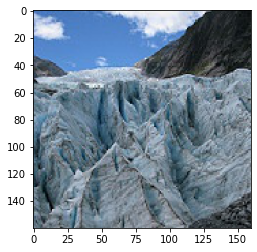

In [19]:
intel_model.load_weights(checkpoint_path)
start = time.time()

testimgpath = test_imgs[np.random.randint(0,len(test_imgs))]
test_img = decode_image(testimgpath)

plt.imshow(np.reshape(test_img,(160,160,3)))

predictions = np.argmax(intel_model.predict(test_img))
end = time.time()
print("CLASS {}".format(CLASS_NAMES[predictions]))
print("time taken to predict {:.2f} mili econds ".format(1000*(end-start)))

## Freeze the Graph models 
with Tf2.0 the freeze graphs models have gone 


In [20]:
tf.saved_model.save(intel_model,'intel_model')

INFO:tensorflow:Assets written to: intel_model/assets


In [38]:
# memory foot print of model 
! du -h /content/intel_model/

model_path = '/content/intel_model'
loaded = tf.keras.models.load_model(model_path)
print("Model has {} trainable variables".format(len(loaded.trainable_variables)))
print(list(loaded.signatures.keys())) 

4.0K	/content/intel_model/assets
240M	/content/intel_model/variables
247M	/content/intel_model/
Model has 192 trainable variables
['serving_default']


## Inferencing with the Freezed model


#### We see that the model memory foot print is same as h5 file almost 240 MB


CLASS sea
time taken to predict 62.85 mili econds 


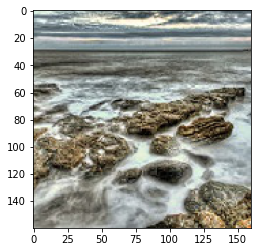

In [40]:
start = time.time()

testimgpath = test_imgs[np.random.randint(0,len(test_imgs))]
test_img = decode_image(testimgpath)

plt.imshow(np.reshape(test_img,(160,160,3)))

predictions = np.argmax(loaded.predict(test_img))
end = time.time()
print("CLASS {}".format(CLASS_NAMES[predictions]))
print("time taken to predict {:.2f} mili econds ".format(1000*(end-start)))

## convert TENSORFLOW-Lite

In [41]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/intel_model') # path to the SavedModel directory
tflite_model = converter.convert()

with open('tflite_model','wb') as file:
  file.write(tflite_model)

In [47]:
! du -h '/content/tflite_model'

92M	/content/tflite_model


In [42]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/tflite_model")
interpreter.allocate_tensors()

In [43]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

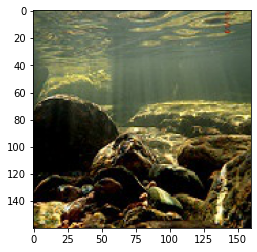

In [49]:
start = time.time()

testimgpath = test_imgs[np.random.randint(0,len(test_imgs))]
test_img = decode_image(testimgpath)
plt.imshow(np.reshape(test_img,(160,160,3)))

In [50]:
# Test model on input data.
input_shape = input_details[0]['shape']
input_data = np.array(test_img, dtype=np.float32)
print(input_data.shape)
print(input_data.dtype)

interpreter.set_tensor(input_details[0]['index'], input_data)

# Model predict
interpreter.invoke()
output_details = interpreter.get_output_details()

# time to predict 
start = time.time()
output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
results = np.squeeze(output_data)
pred = np.argmax(results)
print(results)

(1, 160, 160, 3)
float32
[3.5737993e-04 8.6042327e-01 9.9842258e-02 2.8778177e-02 8.9045949e-03
 1.6943529e-03]


In [51]:
print("CLASS {}".format(CLASS_NAMES[pred]))
print("time taken to predict {:.3f} milli seconds ".format(1000*(end-start)))

CLASS sea
time taken to predict 0.059 milli seconds 
